   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slop

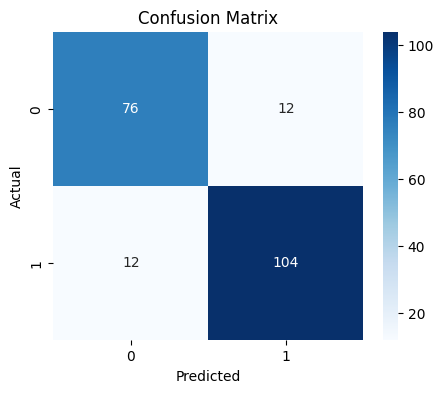

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        88
           1       0.90      0.90      0.90       116

    accuracy                           0.88       204
   macro avg       0.88      0.88      0.88       204
weighted avg       0.88      0.88      0.88       204

 Low Risk of Heart Attack


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb

#  Load Dataset
df = pd.read_csv("/content/heart (3).csv")  # Ensure your dataset file is correct

#  Display first 5 rows
print(df.head())

#  Check for missing values
print(df.isnull().sum())

#  Step 1: Convert Categorical Variables Using Encoders
categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

# Store encoders for future use
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Fit & transform dataset
    encoders[col] = le  # Save encoder for later use

#  Step 2: Define Features and Target
X = df.drop(columns=["HeartDisease"])  # Use the correct target column
y = df["HeartDisease"]

#  Step 3: Balance Data with SMOTE (Handle Class Imbalance)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#  Step 4: Train-Test Split (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#  Step 5: Normalize Features (Standard Scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Step 6: Train XGBoost Model (Better Accuracy)
xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

#  Step 7: Make Predictions
y_pred = xgb_model.predict(X_test)



#  Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  Classification Report
print(classification_report(y_test, y_pred))

#  Step 9: Predict for a New Patient
new_patient = pd.DataFrame({
    "Age": [50], "Sex": ["M"], "ChestPainType": ["ATA"], "RestingBP": [130],
    "Cholesterol": [200], "FastingBS": [1], "RestingECG": ["Normal"], "MaxHR": [80],
    "ExerciseAngina": ["N"], "Oldpeak": [1.2], "ST_Slope": ["Up"]
})

#  Convert Categorical Variables Using the *Stored* Encoders
for col in categorical_features:
    if col in new_patient:
        new_patient[col] = new_patient[col].map(lambda x: encoders[col].transform([x])[0] if x in encoders[col].classes_ else -1)

# Handle unseen categories: Replace -1 with the most common category
for col in categorical_features:
    new_patient[col] = new_patient[col].replace(-1, df[col].mode()[0])  # Mode is the most common category

#  Scale new patient data
new_patient_scaled = scaler.transform(new_patient)

#  Make Prediction
prediction = xgb_model.predict(new_patient_scaled)

if prediction[0] == 1:
    print(" High Risk of Heart Attack")
else:
    print(" Low Risk of Heart Attack")